<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>


### Transformers

En esta práctica introduciremos el modelo de aprendizaje profundo basado en _transformer_ y lo aplicaremos en dos problemas relacionados con el procesamiento de lenguage natural. 


# 0. Introducción
Esta PEC constará de dos ejercicios independientes: 
- En el primero se aplicarán los modelos de transformers a un problema de análisis de sentimiento en textos cortos de twitter,
- En el segundo ejercicio se aplicará este tipo de algorítmos para entrenar un traductor de inglés a francés.

La PEC se puede ejecutar en GPU (opción preferente) o en CPU. Como referencia, el apartado computacionalmente más costoso puede tardar alrededor un par de horas en un computador moderno con un chip i7 reciente. En cualquier caso, estos tiempos meramente orientativos y dependerán de la implementación y del hardware disponible.

# 1. Carga y preprocesado de la base de datos Sentiment 140

La base de datos [Sentiment 140](https://www-cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf) se compone de más de 1 millón de tweets que se han clasificado en función de si el mensaje es negativo (0) o positivo (4). El dataset se puede descargar desde la página de kaggle dedicada a ello:
- https://www.kaggle.com/datasets/kazanova/sentiment140

El objetivo de este ejercicio es entrenar un modelo que, dada una frase cualquiera, sea capaz de predecir si el mensaje es negativo o positivo. Las etapas del ejercicio serán las siguientes:
* Carga, preprocesado, exploración y visualización de los datos. 
* Entrenamiento de un modelo tradicional basado en una RNN o LSTM.
* Entrenamiento de una red que incluya Transformers.
* Optimización automática de los hyperparámetros del Transformer.
* Escalado de la arquitectura y mejora de los resultados. 


In [2]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, TextVectorization

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from IPython.display import clear_output

import optuna
import pathlib
import random
import string
import re

from sklearn.model_selection import train_test_split

## 1.1. Carga y visualizacion de los datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Descarga la base de datos, cargalá con Python, aleatoriza el orden de las filas del dataset y realiza un histograma del número de tweets positivos y tweets negativos.</p>

In [2]:
column_names = ['target','ids','date','flag','user','text']
df = pd.read_csv('/kaggle/input/dataset/data.csv', header=None, names=column_names, encoding='ISO-8859-1')

In [3]:
df = df.sample(frac=1).reset_index(drop=True) #aleatoriza el orden de las filas
df.head()

,target,ids,date,flag,user,text
0,0,2212148486,Wed Jun 17 13:44:08 PDT 2009,NO_QUERY,lmnovo,Alright. Seriously Tweetdeck...what is with Er...
1,0,2238656905,Fri Jun 19 07:34:14 PDT 2009,NO_QUERY,_1981_,"Ran into my ex, damn, she's still beautiful."
2,0,2254408975,Sat Jun 20 09:42:13 PDT 2009,NO_QUERY,ReverbRoyalty,@brandigoldman I'll share the details over a b...
3,4,2181003364,Mon Jun 15 11:14:04 PDT 2009,NO_QUERY,inuyaki,@btn Westphal is sloppy seconds. Rambis turned...
4,0,1932813043,Tue May 26 22:16:44 PDT 2009,NO_QUERY,RoyalAntsJosh,@rickgalan so you'll be out of town on saturda...


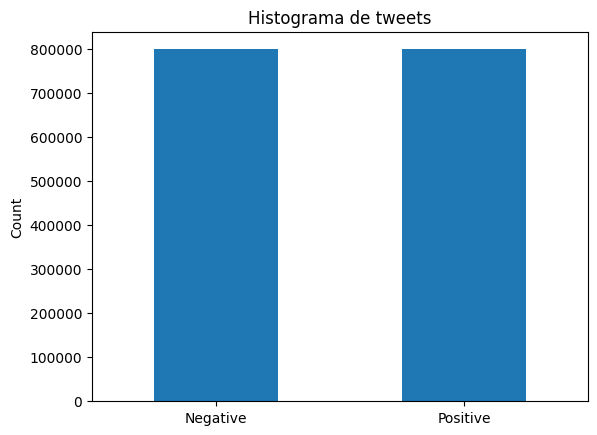

In [4]:
# Count the number of positive and negative texts
counts = df['target'].value_counts()

# Create histogram
fig, ax = plt.subplots()
counts.plot(kind='bar', ax=ax)

# Set labels and title
ax.set_ylabel('Count')
ax.set_title('Histograma de tweets')
ax.set_xticklabels(['Negative', 'Positive'])
ax.tick_params(axis='x', rotation=360)

plt.show()

## 1.2. Visualización de los tweets y procesado del texto

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Muesta 5 tweets distintos, comprobarás que aparecen símbolos de puntuación, palabras en minúsculas o mayúsculas, etc. Realiza una limpieza y estandarización preliminar de todo el texto y luego cuenta las veces que aparece cada palabra y ordenálas. A la palabra que más veces aparece se le asigna el número 1, la siguiente el 2, etc. Representa en escala logarítmica la frequencia de apareción versus el número asignado.</p>
</div>

In [5]:
# Muestra de 5 tweets aleatorios:
random_texts = df['text'].sample(n=5, random_state=45)

for i, text in enumerate(random_texts):
    print(f"Text {i+1}: {text}\n")

Text 1: Previous problem solved!Finally got my itune and ipod synch again   Time to bath and start revising.

Text 2: @Miss_Higgs Sains. gave me a Â£10 gift card without question, because my pizza was 'all dough and very little topping' very appreciated 

Text 3: eating breakfast and drinking coffe - strong coffe! 

Text 4: @ amanduhwood ... hmmm i don't know how i feel about that ... 

Text 5: Happy Father's Day to all you dads out there.  Unfortunately, I lost mine when I was a teenager!  



**Limpieza del texto:**

In [6]:
#Agrego una nueva columna al dataset que contendra el texto limpio
# Convertir a lowercase
df['clean_text'] = df['text'].apply(lambda x: x.lower())

In [7]:
# Eliminacion de signos de puntuacion y caracteres especiales
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [8]:
# Eliminacion de numeros
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'\d+', '', x))

In [9]:
# Eliminacion de espacios en blanco extras: si hay espacio en blanco es solo uno
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'\s+', ' ', x))

In [10]:
# Muestra de 5 tweets aleatorios:
random_texts = df['clean_text'].sample(n=5, random_state=45)

for i, text in enumerate(random_texts):
    print(f"Text {i+1}: {text}\n")

Text 1: previous problem solvedfinally got my itune and ipod synch again time to bath and start revising

Text 2: miss_higgs sains gave me a â gift card without question because my pizza was all dough and very little topping very appreciated 

Text 3: eating breakfast and drinking coffe strong coffe 

Text 4:  amanduhwood hmmm i dont know how i feel about that 

Text 5: happy fathers day to all you dads out there unfortunately i lost mine when i was a teenager 



**Contar las veces que aparece cada palabra:**

In [11]:
# Separacion del texto en palabras
df['words'] = df['clean_text'].apply(lambda x: x.split())

# Frecuencia de cada palabra
word_freq = {}
for words in df['words']:
    for word in words:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

In [12]:
# Palabras en orden descendiente por frecuencia
sorted_words = sorted(word_freq, key=word_freq.get, reverse=True)
# Ranking de palabras en orden segun su frecuencia de aparicion:
word_ranks = {word: rank for rank, word in enumerate(sorted_words, 1)}

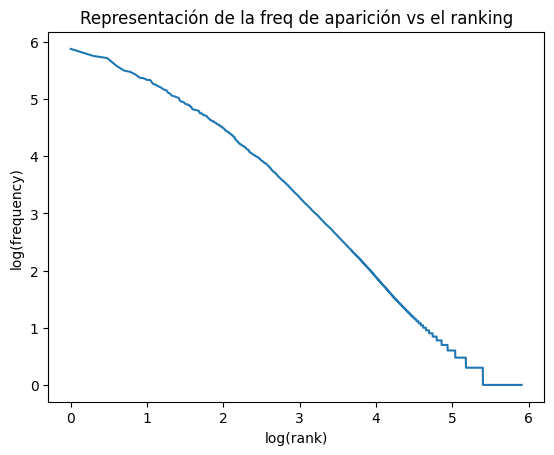

In [13]:
# Grafico de las palabras segun su frecuencia en escala logaritmica
#Cantidad de veces que aparece cada palabra en orden descendiente:
freqs = np.array([word_freq[word] for word in sorted_words]) 
#Ranking de las palabras en orden descendiente:
ranks = np.array([word_ranks[word] for word in sorted_words])

#Aplicamos el logaritmo tanto a la frecuencia como al ranking:
plt.plot(np.log10(ranks), np.log10(freqs))
plt.xlabel('log(rank)')
plt.ylabel('log(frequency)')
plt.title('Representación de la freq de aparición vs el ranking')
plt.show()

## 1.3. Procesado de las etiquetas y tokenización

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Como habrás observado, el lenguaje natural está muy desbalanceado, unas pocas palabras aparecen muchas veces y muchas palabras aparecen en pocas ocasiones. Esta información la tendremos en cuenta para construir posteriormente nuestros vocabulario de tokens, descartando palabras que aparecen poco.
    
Ahora nos vamos a quedar únicamente 20000 frases de todo el dataset. Las etiquetas han de ser convertidas al formato adecuado y se procesaran los textos para obtenerlos en forma de tokens con la función Tokenizer de Tensorflow. Muestra un ejemplo de una frase tokenizada y decodificada de nuevo.

</div>

In [14]:
# Elegimos 20000 frases al azar:
df2 = df.sample(n=20000, random_state=42)

# Convertimos las etiquetas al formato adecuado
df2['target'] = df2['target'].apply(lambda x: 1 if x == 4 else 0)

# Procesamos los textos para obtenerlos en forma de tokens:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df2['clean_text'])
sequences = tokenizer.texts_to_sequences(df2['clean_text'])

In [15]:
# Ejemplo de una frase tokenizada y decodificada: 
sentence = df2['clean_text'].iloc[0]

# Tokenize the sentence using the tokenizer
tokens = tokenizer.texts_to_sequences([sentence])[0]

# Print the original sentence and its tokenized form
print('Original sentence:', sentence)
print('Tokenized sentence:', tokens)

# Decode the tokenized sentence back into text form
decoded_sentence = tokenizer.sequences_to_texts([tokens])[0]

# Print the decoded sentence
print('Decoded sentence:', decoded_sentence)

Original sentence: snack time teddy grams and baked lays 
Tokenized sentence: [4499, 55, 3683, 9002, 7, 2441, 5832]
Decoded sentence: snack time teddy grams and baked lays


## 1.4. Partición de los datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Finalmente deja un 80% de los datos para train y el resto para test. Únicamente se utilizaran 3000 tokens distintos.</div>

Utiliza la función `tf.keras.utils.pad_sequences` para normalizar el tamaño de todas los mensajes tokenizados. El tamaño final será el tamaño del mensaje más largo. Muestra un ejemplo de una frase una vez que se ha aplicado esta función.

In [16]:
# Tokenize the text using the TensorFlow Tokenizer function
tokenizer = Tokenizer(num_words=3000, oov_token='<OOV>')
tokenizer.fit_on_texts(df2['clean_text'])
# Convert the texts to sequences of tokens
sequences = tokenizer.texts_to_sequences(df2['clean_text'])
# Pad the sequences to a maximum length of the longest message
maxlen = max(len(seq) for seq in sequences)

padded_sequences = tf.keras.utils.pad_sequences(sequences, maxlen=maxlen)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df2['target'], test_size=0.2, random_state=42)

In [17]:
# Ejemplo de una frase luego de haber aplicado la función pad_sequences donde se ve como completa con 0 los espacios:
text = df2['clean_text'].iloc[0]
print('Original Text:', text)

tokenized_text = tokenizer.texts_to_sequences([text])
padded_text = tf.keras.utils.pad_sequences(tokenized_text, maxlen=maxlen, padding='post', truncating='post')
print('Padded Text:', padded_text)

Original Text: snack time teddy grams and baked lays 
Padded Text: [[   1   55    1    1    7 2441    1    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]


# 2. Clasificación de tweets

## 2.1 Entrenando el modelo con una RNN o LSTM




<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Utilizando los conocimientos adquiridos hasta ahora, entrenar un modelo de análisis de sentimientos con con una RNN o LSTM. Se proporciona la capa de entrada para facilitar el procesado de los tokens. Representar la accuracy durante el entrenamiento y durante la validación.
Varía los parámetros o la configuración de la red para mejorar el resultado. Finalmente, muestra el mejor resultado obtenido sobre test.
</div>


In [26]:
# Esta capa se proporciona para facilitar la tarea.
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [27]:
# Esto se proporciona
vocab_size=3000
embed_dim=32

inputs = tf.keras.layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(64)(x)
x = tf.keras.layers.Dropout(0.5)(x)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_lstm1 = tf.keras.Model(inputs=inputs, outputs=output_layer)

In [21]:
#Compile the model
model_lstm1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_lstm1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 token_and_position_embeddin  (None, 33, 32)           97056     
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 dropout (Dropout)           (None, 33, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65    

In [31]:
earlystop_callback = EarlyStopping(monitor='loss', patience=10)

In [22]:
#Fit the model
history_lstm1 = model_lstm1.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=100, batch_size=256,
                    callbacks=[earlystop_callback],
                    verbose=1)

Epoch 1/100
63/63 [==============================] - 20s 136ms/step - loss: 0.6805 - binary_accuracy: 0.5667 - val_loss: 0.6375 - val_binary_accuracy: 0.6622
Epoch 2/100
63/63 [==============================] - 4s 59ms/step - loss: 0.5831 - binary_accuracy: 0.7019 - val_loss: 0.5437 - val_binary_accuracy: 0.7390
Epoch 3/100
63/63 [==============================] - 3s 50ms/step - loss: 0.5017 - binary_accuracy: 0.7635 - val_loss: 0.5183 - val_binary_accuracy: 0.7610
Epoch 4/100
63/63 [==============================] - 3s 43ms/step - loss: 0.4666 - binary_accuracy: 0.7855 - val_loss: 0.5066 - val_binary_accuracy: 0.7613
Epoch 5/100
63/63 [==============================] - 1s 24ms/step - loss: 0.4450 - binary_accuracy: 0.7989 - val_loss: 0.5072 - val_binary_accuracy: 0.7638
Epoch 6/100
63/63 [==============================] - 1s 18ms/step - loss: 0.4290 - binary_accuracy: 0.8073 - val_loss: 0.5139 - val_binary_accuracy: 0.7640
Epoch 7/100
63/63 [==============================] - 1s 19ms/s

In [23]:
# Evaluate the model
test_loss_lstm1, test_acc_lstm1 = model_lstm1.evaluate(X_test, y_test)

print("Test loss:", test_loss_lstm1)
print("Test accuracy:", test_acc_lstm1)

125/125 [==============================] - 0s 4ms/step - loss: 1.1941 - binary_accuracy: 0.7163
Test loss: 1.1940901279449463
Test accuracy: 0.7162500023841858


**MODELO 2: Pruebo modificando la cantidad de neuronas de la capa LSTM y agregando una capa LSTM más**

In [24]:
inputs = tf.keras.layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.LSTM(128)(x)
x = tf.keras.layers.Dropout(0.5)(x)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_lstm2 = tf.keras.Model(inputs=inputs, outputs=output_layer)

In [25]:
#Compile the model
model_lstm2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_lstm2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 34)]              0         
                                                                 
 token_and_position_embeddin  (None, 34, 32)           97088     
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 34, 128)           82432     
                                                                 
 dropout_2 (Dropout)         (None, 34, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0   

In [26]:
#Fit the model
history_lstm2 = model_lstm2.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=100, batch_size=256,
                    callbacks=[earlystop_callback],
                    verbose=1)

Epoch 1/100
63/63 [==============================] - 10s 101ms/step - loss: 0.6527 - binary_accuracy: 0.6005 - val_loss: 0.5791 - val_binary_accuracy: 0.7015
Epoch 2/100
63/63 [==============================] - 3s 53ms/step - loss: 0.5128 - binary_accuracy: 0.7542 - val_loss: 0.5251 - val_binary_accuracy: 0.7477
Epoch 3/100
63/63 [==============================] - 3s 49ms/step - loss: 0.4485 - binary_accuracy: 0.7961 - val_loss: 0.5357 - val_binary_accuracy: 0.7400
Epoch 4/100
63/63 [==============================] - 2s 30ms/step - loss: 0.4232 - binary_accuracy: 0.8130 - val_loss: 0.5297 - val_binary_accuracy: 0.7545
Epoch 5/100
63/63 [==============================] - 1s 20ms/step - loss: 0.4029 - binary_accuracy: 0.8227 - val_loss: 0.5399 - val_binary_accuracy: 0.7505
Epoch 6/100
63/63 [==============================] - 1s 22ms/step - loss: 0.3883 - binary_accuracy: 0.8332 - val_loss: 0.5564 - val_binary_accuracy: 0.7390
Epoch 7/100
63/63 [==============================] - 2s 25ms/s

In [27]:
# Evaluate the model
test_loss_lstm2, test_acc_lstm2 = model_lstm2.evaluate(X_test, y_test)

print("Test loss:", test_loss_lstm2)
print("Test accuracy:", test_acc_lstm2)

125/125 [==============================] - 1s 4ms/step - loss: 2.9816 - binary_accuracy: 0.6988
Test loss: 2.981630563735962
Test accuracy: 0.6987500190734863


**MODELO 3: Pruebo otro modelo LSTM pero ahora usando una capa Max Pooling:**

In [28]:
inputs = tf.keras.layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = tf.keras.layers.LSTM(64)(x)
x = tf.keras.layers.Reshape((-1, 64))(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_lstm3 = tf.keras.Model(inputs=inputs, outputs=output_layer)

In [29]:
#Compile the model
model_lstm3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_lstm3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 34)]              0         
                                                                 
 token_and_position_embeddin  (None, 34, 32)           97088     
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 reshape (Reshape)           (None, 1, 64)             0         
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                           

In [30]:
#Fit the model
history_lstm3 = model_lstm3.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=100, batch_size=256,
                    callbacks=[earlystop_callback],
                    verbose=1)

Epoch 1/100
63/63 [==============================] - 8s 88ms/step - loss: 0.6626 - binary_accuracy: 0.6022 - val_loss: 0.5974 - val_binary_accuracy: 0.6858
Epoch 2/100
63/63 [==============================] - 3s 46ms/step - loss: 0.5209 - binary_accuracy: 0.7493 - val_loss: 0.5306 - val_binary_accuracy: 0.7433
Epoch 3/100
63/63 [==============================] - 3s 40ms/step - loss: 0.4514 - binary_accuracy: 0.7926 - val_loss: 0.5108 - val_binary_accuracy: 0.7575
Epoch 4/100
63/63 [==============================] - 1s 23ms/step - loss: 0.4236 - binary_accuracy: 0.8117 - val_loss: 0.5132 - val_binary_accuracy: 0.7605
Epoch 5/100
63/63 [==============================] - 1s 21ms/step - loss: 0.4010 - binary_accuracy: 0.8221 - val_loss: 0.5233 - val_binary_accuracy: 0.7582
Epoch 6/100
63/63 [==============================] - 2s 24ms/step - loss: 0.3859 - binary_accuracy: 0.8327 - val_loss: 0.5326 - val_binary_accuracy: 0.7500
Epoch 7/100
63/63 [==============================] - 1s 12ms/ste

In [31]:
# Evaluate the model
test_loss_lstm3, test_acc_lstm3 = model_lstm3.evaluate(X_test, y_test)

print("Test loss:", test_loss_lstm3)
print("Test accuracy:", test_acc_lstm3)

125/125 [==============================] - 0s 3ms/step - loss: 2.7269 - binary_accuracy: 0.6977
Test loss: 2.7268576622009277
Test accuracy: 0.6977499723434448


**MODELO 4: Pruebo otro modelo usando una capa simple RNN**

In [32]:
inputs = tf.keras.layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.SimpleRNN(64)(x)
x = tf.keras.layers.Dropout(0.5)(x)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_rnn1 = tf.keras.Model(inputs=inputs, outputs=output_layer)

In [33]:
#Compile the model
model_rnn1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_rnn1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 34)]              0         
                                                                 
 token_and_position_embeddin  (None, 34, 32)           97088     
 g_3 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 34, 32)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                6208      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65  

In [34]:
#Fit the model
history_rnn1 = model_rnn1.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=100, batch_size=256,
                    callbacks=[earlystop_callback],
                    verbose=2)

Epoch 1/100
63/63 - 8s - loss: 0.6991 - binary_accuracy: 0.5101 - val_loss: 0.6780 - val_binary_accuracy: 0.6140 - 8s/epoch - 134ms/step
Epoch 2/100
63/63 - 6s - loss: 0.6469 - binary_accuracy: 0.6269 - val_loss: 0.5879 - val_binary_accuracy: 0.7005 - 6s/epoch - 94ms/step
Epoch 3/100
63/63 - 4s - loss: 0.5573 - binary_accuracy: 0.7237 - val_loss: 0.5572 - val_binary_accuracy: 0.7128 - 4s/epoch - 57ms/step
Epoch 4/100
63/63 - 3s - loss: 0.5042 - binary_accuracy: 0.7619 - val_loss: 0.5271 - val_binary_accuracy: 0.7480 - 3s/epoch - 53ms/step
Epoch 5/100
63/63 - 3s - loss: 0.4596 - binary_accuracy: 0.7874 - val_loss: 0.5295 - val_binary_accuracy: 0.7400 - 3s/epoch - 48ms/step
Epoch 6/100
63/63 - 3s - loss: 0.4412 - binary_accuracy: 0.8034 - val_loss: 0.5197 - val_binary_accuracy: 0.7495 - 3s/epoch - 42ms/step
Epoch 7/100
63/63 - 3s - loss: 0.4137 - binary_accuracy: 0.8150 - val_loss: 0.5324 - val_binary_accuracy: 0.7458 - 3s/epoch - 43ms/step
Epoch 8/100
63/63 - 3s - loss: 0.3873 - binary_

In [35]:
# Evaluate the model
test_loss4, test_acc4 = model_rnn1.evaluate(X_test, y_test)

print("Test loss:", test_loss4)
print("Test accuracy:", test_acc4)

125/125 [==============================] - 1s 5ms/step - loss: 1.2303 - binary_accuracy: 0.7005
Test loss: 1.2302885055541992
Test accuracy: 0.7005000114440918


**MODELO 5: Pruebo otro modelo modificando los parámetros de la capa RNN y agregando más**

In [36]:
inputs = tf.keras.layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = tf.keras.layers.Reshape((maxlen, embed_dim))(x)
x = tf.keras.layers.SimpleRNN(128, return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.SimpleRNN(128)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    
model_rnn2 = tf.keras.Model(inputs=inputs, outputs=output_layer)

In [37]:
#Compile the model
model_rnn2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model_rnn2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 34)]              0         
                                                                 
 token_and_position_embeddin  (None, 34, 32)           97088     
 g_4 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 reshape_1 (Reshape)         (None, 34, 32)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 34, 128)           20608     
                                                                 
 dropout_6 (Dropout)         (None, 34, 128)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               3289

In [38]:
#Fit the model
history_rnn2 = model_rnn2.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=100, batch_size=256,
                    callbacks=[earlystop_callback],
                    verbose=2)

Epoch 1/100
63/63 - 14s - loss: 0.7192 - binary_accuracy: 0.5038 - val_loss: 0.6959 - val_binary_accuracy: 0.4975 - 14s/epoch - 215ms/step
Epoch 2/100
63/63 - 8s - loss: 0.7024 - binary_accuracy: 0.5012 - val_loss: 0.6925 - val_binary_accuracy: 0.4983 - 8s/epoch - 129ms/step
Epoch 3/100
63/63 - 7s - loss: 0.6894 - binary_accuracy: 0.5414 - val_loss: 0.6779 - val_binary_accuracy: 0.6085 - 7s/epoch - 119ms/step
Epoch 4/100
63/63 - 6s - loss: 0.6225 - binary_accuracy: 0.6543 - val_loss: 0.5572 - val_binary_accuracy: 0.7240 - 6s/epoch - 102ms/step
Epoch 5/100
63/63 - 6s - loss: 0.5184 - binary_accuracy: 0.7510 - val_loss: 0.5332 - val_binary_accuracy: 0.7322 - 6s/epoch - 93ms/step
Epoch 6/100
63/63 - 6s - loss: 0.4619 - binary_accuracy: 0.7939 - val_loss: 0.5811 - val_binary_accuracy: 0.7370 - 6s/epoch - 95ms/step
Epoch 7/100
63/63 - 6s - loss: 0.4297 - binary_accuracy: 0.8115 - val_loss: 0.5253 - val_binary_accuracy: 0.7540 - 6s/epoch - 98ms/step
Epoch 8/100
63/63 - 6s - loss: 0.3789 - bi

In [39]:
# Evaluate the model
test_loss5, test_acc5 = model_rnn2.evaluate(X_test, y_test)

print("Test loss:", test_loss5)
print("Test accuracy:", test_acc5)

125/125 [==============================] - 1s 8ms/step - loss: 2.8936 - binary_accuracy: 0.6595
Test loss: 2.893599510192871
Test accuracy: 0.659500002861023


**Comparativa del accuracy de los modelos:**

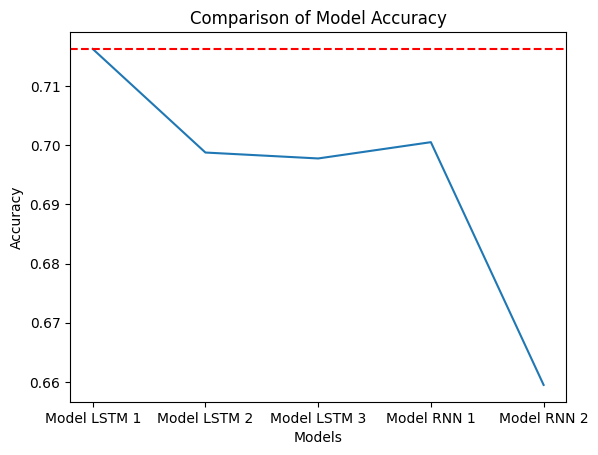

In [40]:
model_names = ['Model LSTM 1', 'Model LSTM 2', 'Model LSTM 3', 'Model RNN 1', 'Model RNN 2']

# create a list of accuracy values
accuracy_values = [test_acc_lstm1, test_acc_lstm2, test_acc_lstm3, test_acc4, test_acc5]

# plot a bar graph of the accuracy values for each model
plt.plot(model_names, accuracy_values)

# add a horizontal line at the maximum accuracy value
plt.axhline(y=max(accuracy_values), color='r', linestyle='--', label='Max Accuracy')

# add labels and a title to the plot
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy')

# display the plot
plt.show()

El modelo con el accuracy más alto es el primero.

## 2.2 Construye una red con dos capas de atención y entrena el modelo de nuevo

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Implementar una arquitectura basada en capas de atención que tendrá la siguiente estructura:
    
* La entrada primero se convierte a posicional embeddings con la función proporcionada TokenAndPositionEmbedding.
* Después habrá una capa MultiHeadAttention, seguida de un dropout y normalizacion
* Se añade otra capa MultiHeadAttention, seguida de un dropout y normalizacion.
* Despues añadir dos redes full connected, la primera con 32 neuronas y la segunda con 16.
* Finalmente añadir una capa de normalizacion, un droput, una capa de GlobalAveragePooling1D
    
Los dropouts serán del 20%, el numero de cabezas de la red Multihead será de 6


In [86]:
# La siguiente estructura se proporciona
# class Transformer(layers.Layer):
#     def __init__(self, sizedense, sizedense2, num_heads):
#         super().__init__()
#         #####.....

#     def call(self, inputs, training):
#         #######
#         return 
    

# sizedense = 64 
# sizedense2 = 16
# num_heads = 6  

# # Input
# inputs = layers.Input(shape=(maxlen,))

# # output
# embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)

# # .....
# # ....



In [23]:
class Transformer(layers.Layer):
    def __init__(self, sizedense, sizedense2, num_heads):
        super().__init__()
        self.attention_layer1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dropout_layer1 = layers.Dropout(0.2)
        self.normalization_layer1 = layers.LayerNormalization(epsilon=1e-6)
        self.attention_layer2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dropout_layer2 = layers.Dropout(0.2)
        self.normalization_layer2 = layers.LayerNormalization(epsilon=1e-6)
        self.dense_layer1 = layers.Dense(sizedense, activation="relu")
        self.dense_layer2 = layers.Dense(sizedense2, activation="relu")
        self.normalization_layer3 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout_layer3 = layers.Dropout(0.2)
        self.pooling_layer = layers.GlobalAveragePooling1D()

    def call(self, inputs, training):
        attention_output1 = self.attention_layer1(inputs, inputs)
        x = self.dropout_layer1(attention_output1, training=training)
        x = self.normalization_layer1(x + attention_output1)
        attention_output2 = self.attention_layer2(x, x)
        x = self.dropout_layer2(attention_output2, training=training)
        x = self.normalization_layer2(x + attention_output2)
        x = self.dense_layer1(x)
        x = self.dense_layer2(x)
        x = self.normalization_layer3(x)
        x = self.dropout_layer3(x, training=training)
        x = self.pooling_layer(x)
        return x

In [28]:
sizedense = 32
sizedense2 = 16
num_heads = 6

vocab_size=3000
embed_dim=32

# Input
inputs = layers.Input(shape=(maxlen,))

# Token and Position Embedding
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)

# Transformer
transformer = Transformer(sizedense, sizedense2, num_heads)
outputs = transformer(embedding_layer, training=True)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [29]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [32]:
# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=100, batch_size=64,callbacks=[earlystop_callback],
                    validation_data=(X_test, y_test))

Epoch 1/100
250/250 [==============================] - 28s 69ms/step - loss: 6.8788 - binary_accuracy: 0.4992 - val_loss: 6.7749 - val_binary_accuracy: 0.5086
Epoch 2/100
250/250 [==============================] - 5s 21ms/step - loss: 6.5571 - binary_accuracy: 0.5076 - val_loss: 5.9021 - val_binary_accuracy: 0.5148
Epoch 3/100
250/250 [==============================] - 3s 12ms/step - loss: 5.6995 - binary_accuracy: 0.5307 - val_loss: 5.1521 - val_binary_accuracy: 0.5110
Epoch 4/100
250/250 [==============================] - 3s 11ms/step - loss: 5.0664 - binary_accuracy: 0.5724 - val_loss: 4.9693 - val_binary_accuracy: 0.5936
Epoch 5/100
250/250 [==============================] - 3s 12ms/step - loss: 4.5446 - binary_accuracy: 0.5669 - val_loss: 4.5991 - val_binary_accuracy: 0.5288
Epoch 6/100
250/250 [==============================] - 3s 13ms/step - loss: 4.6272 - binary_accuracy: 0.5758 - val_loss: 4.5624 - val_binary_accuracy: 0.5996
Epoch 7/100
250/250 [==============================

In [33]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

125/125 [==============================] - 1s 5ms/step - loss: 3.3507 - binary_accuracy: 0.5851
Test accuracy: 0.5850937366485596


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
 Entrena el modelo anterior probando distintos batch sizes, evitando el overfitting y reportando las metricas de loss y accuracy durante el entrenamiento. Muestra finalmente el mejor resultado obtenido y comenta los resultados en comparación con los obtenidos anteriormente.

In [34]:
# Define a list of batch sizes to test
batch_sizes = [16, 32, 64, 128, 256]

# Define empty lists to store results
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Loop over batch sizes and train the model
for batch_size in batch_sizes:
    # Define the model
    sizedense = 32 
    sizedense2 = 16
    num_heads = 6  
    
    # Input
    inputs = layers.Input(shape=(maxlen,))

    # Token and Position Embedding
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)

    # Transformer
    transformer = Transformer(sizedense, sizedense2, num_heads)
    outputs = transformer(embedding_layer, training=True)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

    # Fit the model to the training data
    history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_data=(X_test, y_test),
                        callbacks=[earlystop_callback], verbose=0)
    
    # Store the results
    train_losses.append(history.history['loss'][-1])
    train_accs.append(history.history['binary_accuracy'][-1])
    val_losses.append(history.history['val_loss'][-1])
    val_accs.append(history.history['val_binary_accuracy'][-1])

In [35]:
# Print the results
for i in range(len(batch_sizes)):
    print("Batch size:", batch_sizes[i], "- Train loss:", round(train_losses[i],2), "- Train accuracy:", round(train_accs[i],2),
          "- Validation loss:", round(val_losses[i],2), "- Validation accuracy:", round(val_accs[i],2))

Batch size: 16 - Train loss: 4.39 - Train accuracy: 0.71 - Validation loss: 5.74 - Validation accuracy: 0.59
Batch size: 32 - Train loss: 4.53 - Train accuracy: 0.65 - Validation loss: 4.69 - Validation accuracy: 0.6
Batch size: 64 - Train loss: 3.15 - Train accuracy: 0.73 - Validation loss: 3.32 - Validation accuracy: 0.65
Batch size: 128 - Train loss: 4.22 - Train accuracy: 0.5 - Validation loss: 4.17 - Validation accuracy: 0.5
Batch size: 256 - Train loss: 3.33 - Train accuracy: 0.55 - Validation loss: 3.29 - Validation accuracy: 0.55


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    El accuracy más alto, de 0.64 con el set de validación se obtuvo con un batch size de 65. 
    No se observa una mejora en compararcion con los modelos anteriores, lo cual puede deberse a que el análisis de sentimientos suele requerir una compreónnsi del contexto y el significado de las palabras dentro de la oración, lo cual puede ser capturado de forma eficiente por redes neuronales recurrentes, este tipo de redes está diseñado para tratar secuencias de datos y tienen la habilidad de capturar dependencias temporales, mantienen una memoria interna que retiene información de palabras anteriores dentro de una oración, permitiendo que el modelo comprenda el contexto.
    
<br><br>
</div>

## 2.3. Búsqueda de hyperparámetros de la red

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Vamos a automatizar la busqueda de hyperparametros mediante un grid search. Para ello vamos a tomar como hyperparámetros el número de heads, el batch size y el número de neuronas de la red fully conected. Para cada uno de estos hyperparámetros elige varios valores representativos y entrena un modelo para cada una de las combinaciones. Como el entrenamiento de la red neuronal no es totalmente determinista y se ha restringido el númerode datos, entrena para la misma configuración al menos 5 modelos y guarda la media del mejor accuracy. Haz una representación gráfica <strong>adecuada y explicativa</strong> con la combinacion de hyperparámetros versus resultados.
    
La búsqueda de hiperaparámetros y la representación se pueden realizar de forma manual y con librerías habituales o bien utilizar implementaciones específicas para ello como la librería optuna. Si se utiliza está librería se puede realizar una búsqueda bayesiana (sugerencia opcional) de los hiperparámetros en vez de un simple grid search.
    
Comenta los resultados.
</div>


In [36]:
# Hiperparametros a entrenar:
num_heads_values = [6, 8]
batch_size_values = [32, 64]
sizedense_values = [64, 128]

# Cantidad de entrenamientos:
num_trainings = 5

# Diccionario para guardar el accuracy promedio de cada combinación de hiperparámetros
results = {}

earlystop_callback = EarlyStopping(monitor='loss', patience=3)

# Loop over all combinations of hyperparameters
for num_heads in num_heads_values:
    for batch_size in batch_size_values:
        for sizedense in sizedense_values:
            print(f"Training model with num_heads={num_heads}, batch_size={batch_size}, sizedense={sizedense}")
            
            # Train the model five times and store the best validation accuracy
            val_accs = []
            for i in range(num_trainings):
                sizedense2 = 16
                # Input
                inputs = layers.Input(shape=(maxlen,))

                # Token and Position Embedding
                embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)

                # Transformer
                transformer = Transformer(sizedense, sizedense2, num_heads)
                outputs = transformer(embedding_layer, training=True)

                # Create the model
                model = tf.keras.Model(inputs=inputs, outputs=outputs)

                # Compile the model
                model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

                # Fit the model to the training data
                history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_data=(X_test, y_test),
                                    callbacks=[earlystop_callback], verbose=0)
                #Add the model accuracy to val_accs
                val_accs.append(max(history.history['val_binary_accuracy']))
            
            
            mean_best_val_acc = np.mean(val_accs)
            print(f"Mean Accuracy={mean_best_val_acc}")
            
            # Save the results
            results[(num_heads, batch_size, sizedense)] = mean_best_val_acc
            

Training model with num_heads=6, batch_size=32, sizedense=64
Mean Accuracy=0.6136749982833862
Training model with num_heads=6, batch_size=32, sizedense=128
Mean Accuracy=0.623687493801117
Training model with num_heads=6, batch_size=64, sizedense=64
Mean Accuracy=0.5873687505722046
Training model with num_heads=6, batch_size=64, sizedense=128
Mean Accuracy=0.5518468618392944
Training model with num_heads=8, batch_size=32, sizedense=64
Mean Accuracy=0.6046249866485596
Training model with num_heads=8, batch_size=32, sizedense=128
Mean Accuracy=0.6067093849182129
Training model with num_heads=8, batch_size=64, sizedense=64
Mean Accuracy=0.5530093789100647
Training model with num_heads=8, batch_size=64, sizedense=128
Mean Accuracy=0.5830750107765198


In [37]:
results

{(6, 32, 64): 0.6136749982833862,
 (6, 32, 128): 0.623687493801117,
 (6, 64, 64): 0.5873687505722046,
 (6, 64, 128): 0.5518468618392944,
 (8, 32, 64): 0.6046249866485596,
 (8, 32, 128): 0.6067093849182129,
 (8, 64, 64): 0.5530093789100647,
 (8, 64, 128): 0.5830750107765198}

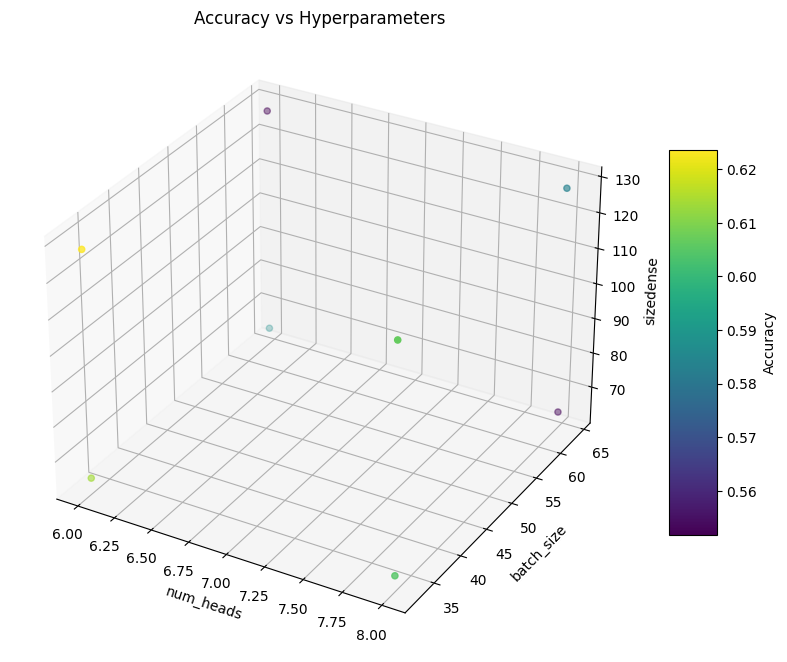

In [38]:
from mpl_toolkits.mplot3d import Axes3D

# Extract the hyperparameters and accuracy values into separate lists
hyperparameters = list(results.keys())
accuracies = list(results.values())

# Extract each hyperparameter into separate lists
x_values = [params[0] for params in hyperparameters]
y_values = [params[1] for params in hyperparameters]
z_values = [params[2] for params in hyperparameters]

# Creo un plot de 3 dimensiones con los hiperparametros en los ejes x,y,z y el accuracy representado por el color
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_values, y_values, z_values, c=accuracies)

# Create a scalar mappable object for the color map
scalar_mappable = plt.cm.ScalarMappable(cmap=plt.cm.cool)
scalar_mappable.set_array(accuracies)

# Add labels and title to the plot
ax.set_xlabel('num_heads')
ax.set_ylabel('batch_size')
ax.set_zlabel('sizedense')
plt.title('Accuracy vs Hyperparameters')

# Add a colorbar to the plot
cbar = plt.colorbar(scatter, shrink=0.5, aspect=8)
cbar.set_label('Accuracy')
plt.show()


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
   En el gráfico se puede ver que los valores de accuracy más altos se obtuvieron con las siguientes combinaciones de hiperparámetros: número de heads 6, batch size 32 y número de neuronas en red fully connected 128. 
    El hiperparámetro número de heads determina cuántos mecanismos de atención en paralelo se usan en el Transformer. Cada uno de ellos aprende diferencias patrones de atención, permitiendo que el modelo capture relaciones más complejas. 
    El batch size se refiere al número de muestras que se procesan en cada entrenamiento antes de la actualización de los parámetros. 
   Por último, la cantidad de neuronas de la capa fully connected determinará la complejidad del modelo y la cantidad de características que podrá aprender.
<br><br>
</div>

## 2.4. Escala los datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
 Ahora entrena el modelo con todos los datos disponibles (dejando un 80% para train y un 20% para test) con los mejores hyperparámetros identificados. Muestra además del mejor resultado, las gráficas de accuracy y loss durante el entrenamiento.
    
Comenta los resultados
</div>


In [22]:
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

# Tokenize the text using the TensorFlow Tokenizer function
tokenizer = Tokenizer(num_words=3000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_text'])
# Convert the texts to sequences of tokens
sequences = tokenizer.texts_to_sequences(df['clean_text'])
# Pad the sequences to a maximum length of the longest message
maxlen = max(len(seq) for seq in sequences)

padded_sequences = tf.keras.utils.pad_sequences(sequences, maxlen=maxlen)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['target'], test_size=0.2, random_state=42)

Entrenamos el modelo con los hiperparametros que conseguimos el mejor accuracy:

**num_heads=6, batch_size=32, sizedense=128**

In [ ]:
earlystop_callback = EarlyStopping(monitor='loss', patience=5)

#Defino el modelo con los mejores hiperparametros encontrados:
inputs = layers.Input(shape=(maxlen,))
# Token and position embedding
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
# Transformer
transformer_block = Transformer(128, 16, 6)
x = transformer_block(x)
# Output
outputs = layers.Dense(1, activation='sigmoid')(x)
# Define the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
#Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=100, batch_size=32,callbacks=[earlystop_callback],
                        validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
500/500 [==============================] - 22s 28ms/step - loss: 0.6699 - binary_accuracy: 0.5574 - val_loss: 0.5627 - val_binary_accuracy: 0.7145
Epoch 2/100
500/500 [==============================] - 6s 12ms/step - loss: 0.4887 - binary_accuracy: 0.7674 - val_loss: 0.5119 - val_binary_accuracy: 0.7585
Epoch 3/100
500/500 [==============================] - 6s 12ms/step - loss: 0.4297 - binary_accuracy: 0.8036 - val_loss: 0.5113 - val_binary_accuracy: 0.7550
Epoch 4/100
500/500 [==============================] - 5s 10ms/step - loss: 0.3989 - binary_accuracy: 0.8161 - val_loss: 0.5587 - val_binary_accuracy: 0.7517
Epoch 5/100
500/500 [==============================] - 5s 10ms/step - loss: 0.3730 - binary_accuracy: 0.8304 - val_loss: 0.5730 - val_binary_accuracy: 0.7530
Epoch 6/100
500/500 [==============================] - 5s 10ms/step - loss: 0.3587 - binary_accuracy: 0.8328 - val_loss: 0.5648 - val_binary_accuracy: 0.7437
Epoch 7/100
500/500 [==============================

In [30]:
def plot_neural_network(model_history):
    # Visualizamos la evolución de la accuracy
    plt.plot(model_history.history['binary_accuracy'])
    plt.plot(model_history.history['val_binary_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

    # Visualizamos la evolución del error cometido por la red
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

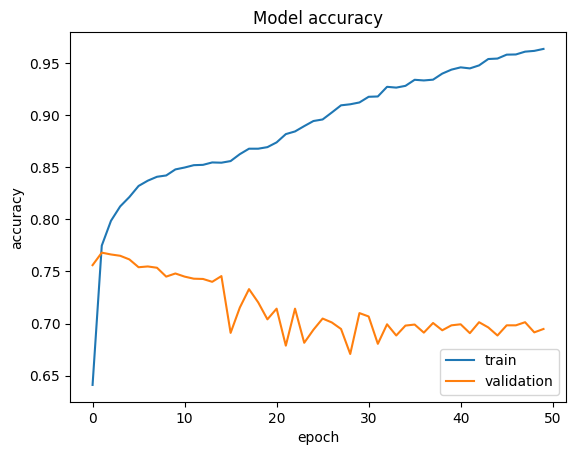

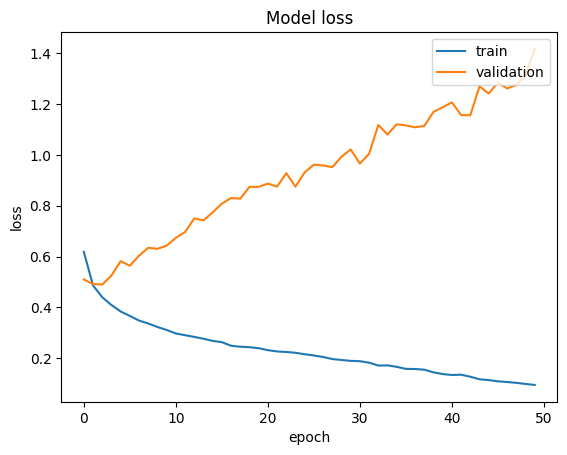

In [31]:
plot_neural_network(history)

In [32]:
# Evaluate the model on the test data using `evaluate`
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

125/125 [==============================] - 0s 3ms/step - loss: 1.4162 - binary_accuracy: 0.6948
Test loss: 1.4161943197250366
Test accuracy: 0.6947500109672546


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    Podemos ver que al aumentar la cantidad de datos de entrenamiento el accuracy del modelo aumenta con respecto a los modelos anteriores que fueron entrenados con una porción del dataset. Esto se debe a que a mayor cantidad de datos, más diversa y representativa se vuelven las muestras de las que el modelo aprende, lo cual puede además reducir los outliers o ruido. 
   <br>
    Además ayuda a prevenir el overfitting, porque el modelo se expone a más variabilidad en los datos, de forma que puede encontrar con más facilidad los patrones.
<br><br>
</div>

## 2.5. Extra 
Al tratarse Sentiment140 de un dataset público es habitual que los investigadores, equipos de data scientist o miembros de la comunidad de la ciencia de datos reporten los resultados obtenidos con sus nuevos algorítmos. En los últimos años se ha hecho popular una página web que reporta los resultados obtenidos por diferentes equipos junto con código reproducible: https://paperswithcode.com/sota/text-classification-on-sentiment140


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
 Este apartado es un ejercicio extra que no es obligatorio realizar. Se trata de explorar los resultados reportados en la url indicada. Comprobarás que los resultados obtenidos están basados en modelos de lenguage de gran tamaño finetuneados sobre el dominio. Se anima al alumno a probar a cambiar la arquitectura utilizada o a utilizar alguno de los modelos y finetunearlo sobre el dominio con la ayuda de librerías como huggingface e intentar obtener resultados que se acerquen (¿o supéren?) a los benchmarks reportados.
</div>

In [ ]:
## Apartado extra opcional.

# 3. Ejercicio sobre traducción de textos
En esta segunda parte vamos a utilizar una base de datos distinta para mostrar uno de los problemas en los que las arquitecturas basadas en transformers son más potentes: la conversión de secuencias a secuencias. En este caso lo vamos a entender como una traducción de un idioma a otro, pero esto es generalizable. Arquitecturas similares se podrían utilizar para convertir una secuencia larga (texto) a una secuencia (resumen), para reducir la complejidad de lectura de un texto, para transcribirlo a lenguaje de signos, etc.

## 3.1 Importación de los datos y preprocesamiento previo
En este caso la base de datos que se va a utilizar es la llamada WMT2014 English-French que contiene frases traducidas entre inglés y frances. 
Los datos se pueden descargar de:
https://paperswithcode.com/sota/machine-translation-on-wmt2014-english-french

Se trata de un fichero enorme. Por ello únicamente se van a utilzar un fragmento de todos los pares de frases del fichero. Se recomienda no cargar todos los datos simultaneamente para evitar problemas de memoria y de tiempo de computación.




<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Al igual que en casos anteriores, el primer paso es cargar y preprocesar los datos de la forma adecuada. Para ello se pide:
    
* Cargar las primeras 100.000 lineas del dataset proporcionado.
* Procesar el dataset de forma que se obtenga una lista de tuplas. El primer elemento de la tupla es la frase en inglés, el segundo elemento es la frase en frances. Al comienzo y final de la frase objetivo hay que añadir un caracter especial de comienzo [start] y fin de frase [end]: e.g. [start] lle découle de notre étonnement [end]
* Limpiar los datos de caracteres extraños, pasar a minusculas, etc.
* Mostrar varios pares de frases para comprobar que está correctamente procesado
* Toma al azar un 80% de los datos como train y el resto como test
* Comprueba que tus datos se llaman train_data y test_data  tienen la forma [(frase ingles, frase francés), (frase ingles,frase francés))  
* Ejecuta la celda que se ha proporcionado para vectorizar y codificar los datos.

</div>

In [3]:
# Column names
column_names = ['en', 'fr']

In [4]:
tr_data = pd.read_csv('/kaggle/input/en-fr-translation-dataset/en-fr.csv', nrows=100000, skiprows=1, names=column_names)

In [5]:
def preprocess(sentence):
    if isinstance(sentence, str):

        # Limpieza de caracteres extraños
        sentence = re.sub(r"[^a-zA-Z0-9\s]", "", sentence)

        # Todo a misuculas
        sentence = sentence.lower()

        # Eliminación de espacios en blanco extras
        sentence = re.sub(r"\s+", " ", sentence).strip()

        # Agregados de tockens al inicio y final de cada frase
        sentence = "[start] " + sentence + " [end]"
    else:
        sentence = ''

    return sentence


In [6]:
# aplicamos la funcion a las columnas del dataset:
tr_data['tr_en'] = tr_data['en'].apply(preprocess)
tr_data['tr_fr'] = tr_data['fr'].apply(preprocess)

**Verificamos que las transformaciones sean correctas:**

In [7]:
tr_data.head(20)

,en,fr,tr_en,tr_fr
0,Changing Lives | Changing Society | How It Wor...,Il a transformé notre vie | Il a transformé la...,[start] changing lives changing society how it...,[start] il a transform notre vie il a transfor...
1,Site map,Plan du site,[start] site map [end],[start] plan du site [end]
2,Feedback,Rétroaction,[start] feedback [end],[start] rtroaction [end]
3,Credits,Crédits,[start] credits [end],[start] crdits [end]
4,Français,English,[start] franais [end],[start] english [end]
5,What is light ?,Qu’est-ce que la lumière?,[start] what is light [end],[start] questce que la lumire [end]
6,The white light spectrum Codes in the light Th...,La découverte du spectre de la lumière blanche...,[start] the white light spectrum codes in the ...,[start] la dcouverte du spectre de la lumire b...
7,The sky of the first inhabitants A contemporar...,Le ciel des premiers habitants La vision conte...,[start] the sky of the first inhabitants a con...,[start] le ciel des premiers habitants la visi...
8,Cartoon,Bande dessinée,[start] cartoon [end],[start] bande dessine [end]
9,Links,Liens,[start] links [end],[start] liens [end]


**Creamos las listas de tuplas:**

In [8]:
sentences = list(zip(tr_data['tr_en'], tr_data['tr_fr']))
sentences[1]

('[start] site map [end]', '[start] plan du site [end]')

In [9]:
# split the data into training and test sets
train_data, test_data = train_test_split(sentences, test_size=0.2, random_state=42)

**Verificamos el formato de los datasets:**

In [10]:
print(train_data[100])
print(test_data[100])

('[start] the government of canada supports efforts to combat violence against girls and women 20071113 status of women canada [end]', '[start] le gouvernement du canada appuie les efforts de lutte contre la violence faite aux filles et aux femmes 20071113 condition fminine canada [end]')
('[start] thailand and germany collaborate on international conference thailand and germany will be cohosting an international conference on food safety and nutrition to assist the creation of new international food standards [end]', '[start] la thalande et lallemagne collaborent pour organiser une confrence internationale la thalande et lallemagne seront les htes conjoints dune confrence internationale sur la salubrit des aliments et la nutrition laquelle vise la cration de nouvelles normes alimentaires internationales [end]')


In [11]:
###########################################################
# Esta celda para vectorizar los datos se propociona ######
###########################################################

vocab_size = 15000
sequence_length = 20
batch_size = 64

eng_vectorization = TextVectorization(max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,)
fr_vectorization = TextVectorization(max_tokens=vocab_size,output_mode="int",output_sequence_length=sequence_length + 1,)

train_eng_texts = [pair[0] for pair in train_data]
train_fr_texts = [pair[1] for pair in train_data]

eng_vectorization.adapt(train_eng_texts)
fr_vectorization.adapt(train_fr_texts)


def format_dataset(eng, fr):
    eng = eng_vectorization(eng)
    fr = fr_vectorization(fr)
    return ({"encoder_inputs": eng, "decoder_inputs": fr[:, :-1],}, fr[:, 1:])


def make_dataset(pairs):
    eng_texts, fr_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    fr_texts = list(fr_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fr_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_vectorized = make_dataset(train_data)

val_vectorized = make_dataset(test_data)

In [12]:
first_element = next(iter(val_vectorized))

print((first_element))

({'encoder_inputs': <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[   4,  583,    8, ...,    0,    0,    0],
       [   4, 2915,    3, ...,    0,    0,    0],
       [   4,   41,  655, ...,   34, 1017,    3],
       ...,
       [   4,  155, 2977, ..., 2211,   20,  141],
       [   4,    2,    1, ...,  369,  621,    2],
       [   4,  449,    7, ...,  387,   92,  258]])>, 'decoder_inputs': <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[   4, 1827,    6, ...,    0,    0,    0],
       [   4,   26, 6088, ...,    0,    0,    0],
       [   4,    7,   85, ...,    6,  130,    1],
       ...,
       [   4,  132,    9, ...,   43,   25,  289],
       [   4,    1,   13, ...,  210,   48,   86],
       [   4, 1655,    7, ..., 4955,    9,  439]])>}, <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[1827,    6, 4143, ...,    0,    0,    0],
       [  26, 6088,    3, ...,    0,    0,    0],
       [   7,   85,  632, ...,  130,    1,   56],
       ...,
       [ 132,    9,   72,

## 3.2. Modifica el bloque de transformer
A continuación se proporciona un bloque transformer del tipo seq2seq con un encoder y un decoder antes de la salida. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong></p> Se propone realizar algunos cambios sobre la implementación del bloque transformer:
    
* Añade una capa de atención de una sola cabeza al final del encoder.
* Añade una capa fully connected en el encoder
* Duplica el bloque encoder
* Añade una capa de dropout despues del bloque del decoder.

</div>

In [ ]:
""""
########################################
# Codigo proporcionado #################
########################################
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=padding_mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(query=inputs, value=inputs, key=inputs, attention_mask=causal_mask)
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(query=out_1,value=encoder_outputs,key=encoder_outputs,attention_mask=padding_mask,)
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_1)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

embed_dim = 128
latent_dim = 1024
num_heads = 2

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)

decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")
""""

In [13]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.attention_2 = layers.MultiHeadAttention(num_heads=1, key_dim=embed_dim) #Añade una capa de atencion con num_head=1
        self.dense = layers.Dense(embed_dim, activation="relu") #Añade una capa fully connected 
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention_1(query=inputs, value=inputs, key=inputs, attention_mask=padding_mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        attention_output = self.attention_2(query=proj_output, value=proj_output, key=proj_output)
        dense_output = self.dense(attention_output)
        return self.layernorm_2(proj_output + dense_output)

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)   
    
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True
        self.dropout = layers.Dropout(0.5) #Añade una capa dropout al final del decoder

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(query=inputs, value=inputs, key=inputs, attention_mask=causal_mask)
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(query=out_1,value=encoder_outputs,key=encoder_outputs,attention_mask=padding_mask,)
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_1)
        out_3 = self.layernorm_3(out_2 + proj_output)

        return self.dropout(out_3)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    

In [14]:
embed_dim = 128
latent_dim = 1024
num_heads = 2

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs_1 = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder_outputs_2 = TransformerEncoder(embed_dim, latent_dim, num_heads)(encoder_outputs_1)#Duplica el bloque encoder
encoder = keras.Model(encoder_inputs, encoder_outputs_2)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)

decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs_2])
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")

## 3.3. Entrena el modelo


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Entrena el modelo mostrando las gráficas de loss y accuracy. La accuracy no es una métricas que habitualmente se utilice en el entrenamiento de modelos de traducción. Lo habitual en este tipo de problemas sería utilizar la métrica BLEU basada en n-gramas (https://en.wikipedia.org/wiki/BLEU). Sin embargo, el bleu no está nativamente disponible en tensorflow para compilar el modelo así que como referencia se utilizará el accuracy que sería equivalente a la métrica de BLEU considerándo únicamente n-gramas de tamaño 1.

In [15]:
early_stop = EarlyStopping(monitor="val_loss", patience=10)

# Compile the model
transformer.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 128)   1922560     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 transformer_encoder (Transform  (None, None, 128)   478336      ['positional_embedding[0][0]']   
 erEncoder)                                                                                       
                                                                                        

In [16]:
# Train the model
history = transformer.fit(train_vectorized, epochs=100, validation_data=val_vectorized,callbacks=[early_stop])

Epoch 1/100
1250/1250 [==============================] - 121s 79ms/step - loss: 5.6125 - accuracy: 0.1807 - val_loss: 4.8302 - val_accuracy: 0.2283
Epoch 2/100
1250/1250 [==============================] - 68s 55ms/step - loss: 4.8369 - accuracy: 0.2316 - val_loss: 4.4909 - val_accuracy: 0.2534
Epoch 3/100
1250/1250 [==============================] - 65s 52ms/step - loss: 4.5531 - accuracy: 0.2521 - val_loss: 4.3395 - val_accuracy: 0.2658
Epoch 4/100
1250/1250 [==============================] - 65s 52ms/step - loss: 4.3788 - accuracy: 0.2654 - val_loss: 4.2604 - val_accuracy: 0.2728
Epoch 5/100
1250/1250 [==============================] - 64s 51ms/step - loss: 4.2527 - accuracy: 0.2758 - val_loss: 4.2075 - val_accuracy: 0.2773
Epoch 6/100
1250/1250 [==============================] - 65s 52ms/step - loss: 4.1505 - accuracy: 0.2843 - val_loss: 4.1796 - val_accuracy: 0.2806
Epoch 7/100
1250/1250 [==============================] - 65s 52ms/step - loss: 4.0683 - accuracy: 0.2915 - val_loss: 

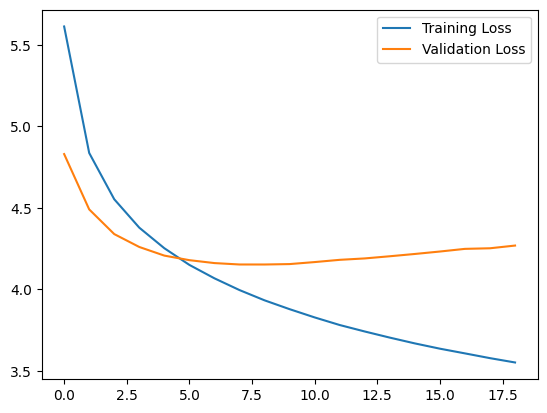

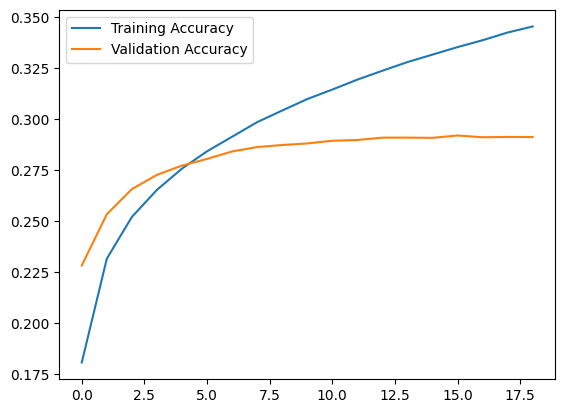

In [17]:
# Plot the loss and accuracy graphs
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()


In [18]:
# Evaluate the model on the test data using `evaluate`
loss, accuracy = transformer.evaluate(val_vectorized)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

313/313 [==============================] - 10s 30ms/step - loss: 4.2691 - accuracy: 0.2913
Test loss: 4.269136905670166
Test accuracy: 0.2913193106651306


## 3.4. Realiza una predicción sobre el dataset de test.
El modelo transformer es regresivo, esto quiere decir que para hacer la predicción se utiliza tanto el input de entrada como las predicciones ya realizadas. De hecho, este es uno de los principales motivos de las alucinaciones que sufren los modelos basados en transformers. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
 Se proporciona una funcion para decodificar una frase con el modelo entrenado . Hacer las modificaciones oportunas e importar las funciones necesarias para calcular el Bleu score sobre un subconjunto del test, por ejemplo sobre 100 frases.

Finalmente realiza alguna mejora a tu elección para conseguir un modelo con mejor Bleu (comprobándolo). Se puede añadir más datos al train, modificar la arquitectura, variar los hiperparámetros, etc. Se sugiere modificar el  dropout a un valor más habitual en la literatura. 
    
Compara tus resultados con los que aparecen en la url de paperswithcode y comentalos.

In [19]:
###  Codigo proporcionado ############
fr_vocab = fr_vectorization.get_vocabulary()
fr_index_lookup = dict(zip(range(len(fr_vocab)), fr_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence, transformer):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = fr_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = fr_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [20]:
test_data[1]

('[start] ideas brew during the airmen talks north discussions 20060706 national defence [end]',
 '[start] brassage dides au cours de la confrence airman talks north 20060706 dfense nationale [end]')

In [21]:
decode_sequence(test_data[1][0], transformer)

'[start] le nouveau gouvernement du canada annonce des modifications aux programmes visant amliorer la scurit des produits de la mer et'

In [24]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def calculate_bleu_score(subset_size, test_data, transformer):
    # Subset of test sentences and reference translations
    test_subset = test_data[:subset_size][0]
    reference_subset = test_data[:subset_size][1]

    # Generate translations using decode_sequence
    translations = [decode_sequence(sentence, transformer) for sentence in test_subset]

    # Tokenize reference translations
    tokenized_references = [[translation.split()] for translation in reference_subset]

    # Tokenize generated translations
    tokenized_translations = [translation.split() for translation in translations]
    
    # Calculate BLEU score with smoothing function
    smoothing = SmoothingFunction().method4  # Use smoothing
    bleu_score = corpus_bleu(tokenized_references, tokenized_translations, smoothing_function=smoothing)

    return bleu_score

In [25]:
# Call the function and print the BLEU score
bleu_score = calculate_bleu_score(100, test_data, transformer)
print("BLEU score:", bleu_score)

BLEU score: 0.10893333098810543


Un BLEU (Bilingual Evaluation Understudy) score de 0.22 indica el nivel de similitud o solapamiento entre las traducciones generadas y las de referencia, es decir los datos reales del set de test. El BLEU score tiene un rango de 0 a 1, un valor mas alto indica mejor performance del modelo como traductor.
En este caso, un valor de 0.22 indica baja similitud y que el modelo tiene baja calidad de traduccion

**Pruebo agregando mas datos para entrenar el modelo:**

In [26]:
tr_data2 = pd.read_csv('/kaggle/input/en-fr-translation-dataset/en-fr.csv', nrows=200000)

# aplicamos la funcion a las columnas del dataset para el pre procesamiento de las frases:
tr_data2['tr_en'] = tr_data2['en'].apply(preprocess)
tr_data2['tr_fr'] = tr_data2['fr'].apply(preprocess)

#Creamos las tuplas:
sentences2 = list(zip(tr_data2['tr_en'], tr_data2['tr_fr']))

#Separamos los datos para train y test:
train_data2, test_data2 = train_test_split(sentences2, test_size=0.2, random_state=42)

In [28]:
# Vectorizar los datos:

train_eng_texts2 = [pair[0] for pair in train_data2]
train_fr_texts2 = [pair[1] for pair in train_data2]

eng_vectorization.adapt(train_eng_texts2)
fr_vectorization.adapt(train_fr_texts2)

def format_dataset(eng, fr):
    eng = eng_vectorization(eng)
    fr = fr_vectorization(fr)
    return ({"encoder_inputs": eng, "decoder_inputs": fr[:, :-1],}, fr[:, 1:])


def make_dataset(pairs):
    eng_texts, fr_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    fr_texts = list(fr_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fr_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()

train_vectorized2 = make_dataset(train_data2)
val_vectorized2 = make_dataset(test_data2)

In [29]:
transformer2 = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer2")

In [30]:
early_stop = EarlyStopping(monitor="val_loss", patience=10)

# Compile the model
transformer2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

transformer2.summary()

Model: "transformer2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 128)   1922560     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 transformer_encoder (Transform  (None, None, 128)   478336      ['positional_embedding[0][0]']   
 erEncoder)                                                                                       
                                                                                       

In [31]:
# Train the model
history2 = transformer2.fit(train_vectorized2, epochs=100, validation_data=val_vectorized2,callbacks=[early_stop])

Epoch 1/100
2500/2500 [==============================] - 176s 64ms/step - loss: 5.5584 - accuracy: 0.1796 - val_loss: 4.8358 - val_accuracy: 0.2250
Epoch 2/100
2500/2500 [==============================] - 129s 51ms/step - loss: 4.8244 - accuracy: 0.2277 - val_loss: 4.5252 - val_accuracy: 0.2479
Epoch 3/100
2500/2500 [==============================] - 129s 52ms/step - loss: 4.5776 - accuracy: 0.2444 - val_loss: 4.3798 - val_accuracy: 0.2593
Epoch 4/100
2500/2500 [==============================] - 128s 51ms/step - loss: 4.4308 - accuracy: 0.2553 - val_loss: 4.2991 - val_accuracy: 0.2654
Epoch 5/100
2500/2500 [==============================] - 129s 52ms/step - loss: 4.3300 - accuracy: 0.2633 - val_loss: 4.2432 - val_accuracy: 0.2698
Epoch 6/100
2500/2500 [==============================] - 130s 52ms/step - loss: 4.2517 - accuracy: 0.2698 - val_loss: 4.2089 - val_accuracy: 0.2734
Epoch 7/100
2500/2500 [==============================] - 130s 52ms/step - loss: 4.1919 - accuracy: 0.2746 - val_

In [32]:
# Evaluate the model on the test data using `evaluate`
loss, accuracy = transformer2.evaluate(val_vectorized2)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

625/625 [==============================] - 19s 31ms/step - loss: 4.1772 - accuracy: 0.2843
Test loss: 4.177190780639648
Test accuracy: 0.2843303978443146


In [34]:
# Call the function and print the BLEU score
bleu_score2 = calculate_bleu_score(100, test_data2, transformer2)
print("BLEU score:", bleu_score2)

BLEU score: 0.18068537884315472


Agregando el doble de frases traducidas para entrenal el modelo se logra mejorar la performance con un BLEU score de 0.18, pero el modelo sigue performando mal.

**Pruebo modificando hiperparámetros:**

In [50]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.attention_2 = layers.MultiHeadAttention(num_heads=1, key_dim=embed_dim) #Añade una capa de atencion con num_head=1
        self.dense = layers.Dense(embed_dim, activation="relu") #Añade una capa fully connected 
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention_1(query=inputs, value=inputs, key=inputs, attention_mask=padding_mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        attention_output = self.attention_2(query=proj_output, value=proj_output, key=proj_output)
        dense_output = self.dense(attention_output)
        return self.layernorm_2(proj_output + dense_output)

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)   
    
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True
        self.dropout = layers.Dropout(0.2) #Añade una capa dropout al final del decoder

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(query=inputs, value=inputs, key=inputs, attention_mask=causal_mask)
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(query=out_1,value=encoder_outputs,key=encoder_outputs,attention_mask=padding_mask,)
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_1)
        out_3 = self.layernorm_3(out_2 + proj_output)

        return self.dropout(out_3)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    

In [51]:
embed_dim = 128
latent_dim = 1024
num_heads = 4

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs_1 = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder_outputs_2 = TransformerEncoder(embed_dim, latent_dim, num_heads)(encoder_outputs_1)#Duplica el bloque encoder
encoder = keras.Model(encoder_inputs, encoder_outputs_2)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)

decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs_2])

In [52]:
transformer3 = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer3")

In [53]:
early_stop = EarlyStopping(monitor="val_loss", patience=10)

# Compile the model
transformer3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

transformer3.summary()

Model: "transformer3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_6 (Positi  (None, None, 128)   1922560     ['encoder_inputs[0][0]']         
 onalEmbedding)                                                                                   
                                                                                                  
 transformer_encoder_6 (Transfo  (None, None, 128)   610176      ['positional_embedding_6[0][0]'] 
 rmerEncoder)                                                                                     
                                                                                       

In [54]:
# Train the model
history3 = transformer3.fit(train_vectorized, epochs=100, validation_data=val_vectorized,callbacks=[early_stop])

Epoch 1/100
1250/1250 [==============================] - 107s 74ms/step - loss: 5.2802 - accuracy: 0.2043 - val_loss: 4.5186 - val_accuracy: 0.2540
Epoch 2/100
1250/1250 [==============================] - 66s 53ms/step - loss: 4.3520 - accuracy: 0.2661 - val_loss: 4.1696 - val_accuracy: 0.2822
Epoch 3/100
1250/1250 [==============================] - 67s 54ms/step - loss: 4.0129 - accuracy: 0.2892 - val_loss: 4.0942 - val_accuracy: 0.2885
Epoch 4/100
1250/1250 [==============================] - 65s 52ms/step - loss: 3.8099 - accuracy: 0.3044 - val_loss: 4.0134 - val_accuracy: 0.2984
Epoch 5/100
1250/1250 [==============================] - 65s 52ms/step - loss: 3.6825 - accuracy: 0.3139 - val_loss: 4.0300 - val_accuracy: 0.2993
Epoch 6/100
1250/1250 [==============================] - 65s 52ms/step - loss: 3.5603 - accuracy: 0.3256 - val_loss: 4.0320 - val_accuracy: 0.3018
Epoch 7/100
1250/1250 [==============================] - 65s 52ms/step - loss: 3.4527 - accuracy: 0.3367 - val_loss: 

In [55]:
# Evaluate the model on the test data using `evaluate`
loss, accuracy = transformer3.evaluate(val_vectorized)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

313/313 [==============================] - 10s 31ms/step - loss: 4.3042 - accuracy: 0.2997
Test loss: 4.30424690246582
Test accuracy: 0.29971060156822205


In [57]:
# Call the function and print the BLEU score
bleu_score3 = calculate_bleu_score(100, test_data, transformer3)
print("BLEU score:", bleu_score3)

BLEU score: 0.18184804078107475


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
        El mejor BLEU que obtuve fue de 0.18 lo cual indica una mala performance del traductor.
        <br> 
        En comparación con los resultados publicados en la web 'papers with code', el resultado está muy por debajo del mínimo que es 0.345.
         <br> 
        Algunas accioines que píoadrn implementarse para mejorar la performance son:
         <br> 
    - Aumentar el tamaño del dataset de entrenamiento para que el modelo pueda tener una mejor representación de lo que tiene que hacer.
    <br> 
    - Modificar o complejizar la arquitectura del modelo: Podría intentar aumentando la cantidad de capas o la cantidad de attention heads para que el modelo pueda capturar mejor los patrones más complejos y las dependencias.
    <br> 
    - Probar con otros hiperparámetros: Probar entrenando el modelo con distintos valores de learning rate o batch size.
<br><br>
</div>